In [2]:
import pandas as pd

# Load the CSV file to inspect its content
data_july_2021 = pd.read_csv('PeopleSense_Data - July 23 2021.csv')
data_july_2021.head()


,CarPosition,ConsistNum,DerivedCount,DeviceID,EndTime,LastPriorStation,LastScan,LastStation,Latitude,LocationID,...,MilesToNextStation,Mode,NextStation,Occupancy,ScannedCount,Speed,StartTime,TotalScans,TrainNum,TrainWithCar
0,4,NaN,4.5,00PS-POC9-01,2021-04-26 12:20:04,Unknown,5,Unknown,38.597835,8302,...,Unknown,In Transit - Trip Started,Unknown,5,4.5,0.903724,2021-04-26 12:14:59,11,537,NaN
1,4,NaN,5.3,00PS-POC9-01,2021-04-26 12:24:36,Unknown,5,Unknown,38.597835,8302,...,Unknown,Stopped At Mid-Way,Unknown,6,5.3,0.903724,2021-04-26 12:20:30,7,537,NaN
2,4,NaN,3.9,00PS-POC9-01,2021-04-26 12:30:31,Unknown,4,Unknown,38.597835,8302,...,Unknown,Stopped At Mid-Way,Unknown,5,3.9,0.903724,2021-04-26 12:26:01,9,537,NaN
3,4,NaN,3.8,00PS-POC9-01,2021-04-26 12:35:40,Unknown,3,Unknown,38.597835,8302,...,Unknown,Stopped At Mid-Way,Unknown,5,3.8,0.903724,2021-04-26 12:31:04,11,537,NaN
4,4,NaN,2.9,00PS-POC9-01,2021-04-26 12:40:52,Unknown,4,Unknown,38.597835,8302,...,Unknown,Stopped At Mid-Way,Unknown,3,2.9,0.903724,2021-04-26 12:36:00,12,537,NaN


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Selecting relevant columns
relevant_columns = ['DerivedCount', 'Occupancy', 'ScannedCount', 'Speed', 'CarPosition']
data_selected = data_july_2021[relevant_columns]

# Handling missing values by dropping them
data_cleaned = data_selected.dropna()

# Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# Applying PCA
pca = PCA(n_components=2)  # We reduce the dimensionality to 2 for visualization purposes
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

principal_df.head(), explained_variance


(   Principal Component 1  Principal Component 2
 0              -1.600016              -0.841645
 1              -1.541814              -0.845788
 2              -1.628147              -0.839623
 3              -1.632835              -0.839286
 4              -1.716422              -0.833360,
 array([0.64254368, 0.19764375]))

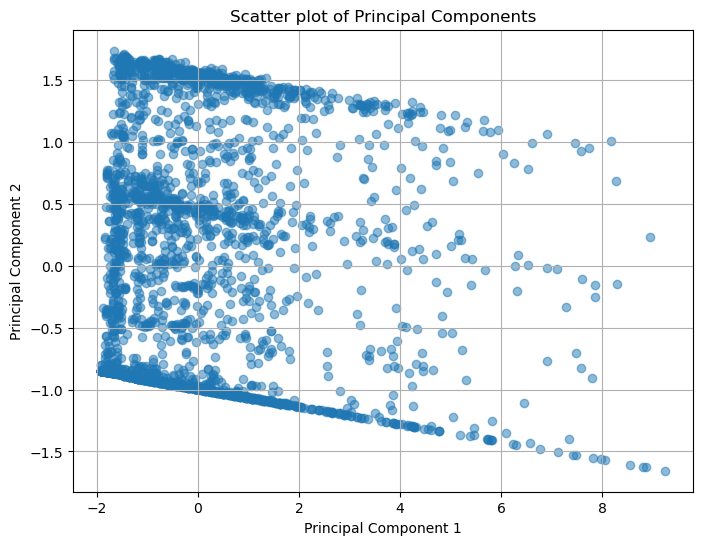

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


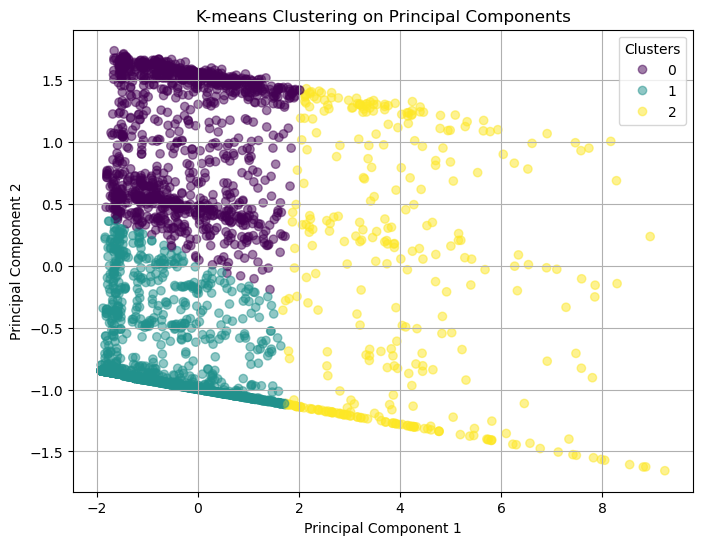

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Visualization of PCA results
plt.figure(figsize=(8, 6))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)
plt.title('Scatter plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Applying K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(principal_df)
labels = kmeans.labels_

# Visualization of clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], c=labels, alpha=0.5)
plt.title('K-means Clustering on Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


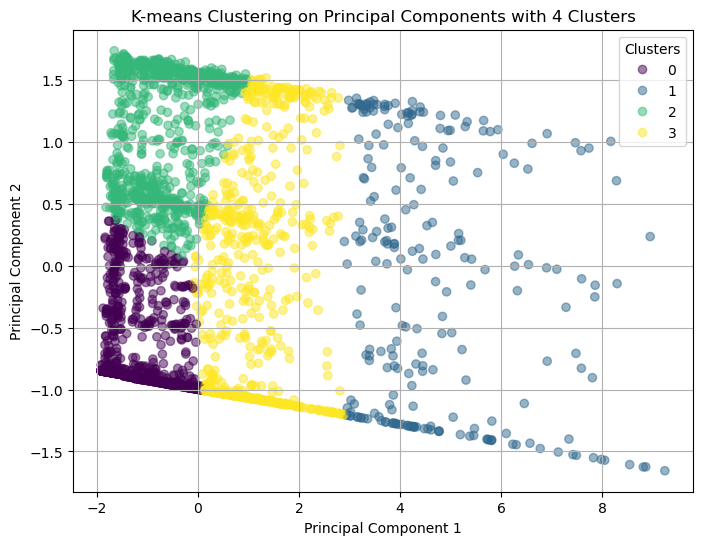

,DerivedCount,Occupancy,ScannedCount,Speed,CarPosition
0,6.989842,8.176477,7.043605,5.823950,2.743920
1,82.179543,92.157402,80.599851,37.960020,0.512256
2,11.054884,12.803934,11.081182,63.873152,2.636136
3,35.054851,39.536247,34.508263,26.467964,1.912914


In [5]:
# Applying K-means clustering with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(principal_df)
labels_4 = kmeans_4.labels_

# Transforming cluster centers back to the original feature space
cluster_centers_4 = scaler.inverse_transform(pca.inverse_transform(kmeans_4.cluster_centers_))

# Creating a DataFrame for the cluster centers with 4 clusters
cluster_centers_4_df = pd.DataFrame(data=cluster_centers_4, columns=relevant_columns)

# Visualization of clusters with 4 groups
plt.figure(figsize=(8, 6))
scatter_4 = plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], c=labels_4, alpha=0.5)
plt.title('K-means Clustering on Principal Components with 4 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_4.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

cluster_centers_4_df


In [6]:
# Convert 'StartTime' to datetime format and extract features
data_july_2021['StartTime'] = pd.to_datetime(data_july_2021['StartTime'])
data_july_2021['HourOfDay'] = data_july_2021['StartTime'].dt.hour
data_july_2021['DayOfWeek'] = data_july_2021['StartTime'].dt.dayofweek  # Monday=0, Sunday=6

# Selecting relevant features for the model
features = ['HourOfDay', 'DayOfWeek', 'DerivedCount', 'ScannedCount', 'Speed', 'CarPosition']
target = 'Occupancy'

# Prepare feature matrix and target vector
X = data_july_2021[features]
y = data_july_2021[target]

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the prepared data
X_train.head(), y_train.head()


(      HourOfDay  DayOfWeek  DerivedCount  ScannedCount      Speed  CarPosition
 1398         19          5          84.0          84.0  37.332292            1
 693           6          2          11.3          11.3  45.870692            4
 1089          8          6          66.8          44.0  67.121622            2
 1837          4          3          11.2          11.2  73.074119            1
 2874          9          3          28.5          28.5   0.011185            2,
 1398    93
 693     13
 1089    74
 1837    12
 2874    34
 Name: Occupancy, dtype: int64)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Training the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = lr_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(0.5959431023332566, 0.9990186971392097)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setting up the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Parameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Setting up GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
best_params = grid_search.best_params_

# Evaluating the best model from grid search
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

best_params, mae_rf, r2_rf


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_d

({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.32049751243781094,
 0.9989700881603749)

In [10]:
# Simplified parameters for GridSearchCV to reduce computation time
param_grid_simplified = {
    'n_estimators': [100],  # Using just one option for the number of trees
    'max_depth': [None, 10],  # Simplified depth options
    'min_samples_split': [2],  # Using the default value
    'min_samples_leaf': [1, 4]  # Two options for the minimum samples at a leaf
}

# Setting up GridSearchCV with simplified parameters
grid_search_simplified = GridSearchCV(estimator=rf_model, param_grid=param_grid_simplified, cv=2, scoring='neg_mean_absolute_error', verbose=2)
grid_search_simplified.fit(X_train, y_train)

# Best parameters from the simplified grid search
best_params_simplified = grid_search_simplified.best_params_

# Evaluating the best model from simplified grid search
best_rf_model_simplified = grid_search_simplified.best_estimator_
y_pred_rf_simplified = best_rf_model_simplified.predict(X_test)
mae_rf_simplified = mean_absolute_error(y_test, y_pred_rf_simplified)
r2_rf_simplified = r2_score(y_test, y_pred_rf_simplified)

best_params_simplified, mae_rf_simplified, r2_rf_simplified


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s


({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.3156716417910448,
 0.9990518391551378)